# Issue GMC Registation Credentials to Doctors

## Before running through this notebook you should have configured the GMC agent in [Part 3.1- Part 3.1 - Initialising the GMC Agent](http://localhost:8890/notebooks/Part%203.1%20-%20Initialising%20the%20GMC%20Agent.ipynb).

In this notebook you will connect to the GMC, prove you have a medical qualification and receive a GMC Registration credential.

## 1. Initialise a controller for the GMC

In [1]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8032
WEBHOOK_BASE = ""
ADMIN_URL = "http://gmc-agent:8031"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [2]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 7. Download Identity Holder Mobile SSI Wallet
Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 8. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scan this QR code and then communicate back to the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

## 8a. Create an Invitation

In [3]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'connection_id': '255cdcc1-4b68-427d-8a6e-200fe75e6dc3', 'routing_state': 'none', 'invitation_mode': 'once', 'updated_at': '2020-09-22 09:37:53.153513Z', 'invitation_key': 'BdrrnhGgvSpJExbDBHqst9cLKqsdY31q6GnNcsfJ3Bf5', 'accept': 'auto', 'initiator': 'self', 'created_at': '2020-09-22 09:37:53.153513Z', 'state': 'invitation'} 255cdcc1-4b68-427d-8a6e-200fe75e6dc3
Connection ID 255cdcc1-4b68-427d-8a6e-200fe75e6dc3
Invitation
https://06158b3cad78.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiNmZmYjU2ZjgtNDVjYS00MzVjLWIyMDAtMjI4OGNlNTNhMGZlIiwgInJlY2lwaWVudEtleXMiOiBbIkJkcnJuaEdndlNwSkV4YkRCSHFzdDljTEtxc2RZMzFxNkduTmNzZkozQmY1Il0sICJzZXJ2aWNlRW5kcG9pbnQiOiAiaHR0cHM6Ly8wNjE1OGIzY2FkNzgubmdyb2suaW8iLCAibGFiZWwiOiAiR2VuZXJhbCBNZWRpY2FsIENvdW5jaWwifQ==


## 8b. Generate QR Code to be scanned with Mobile SSI Wallet

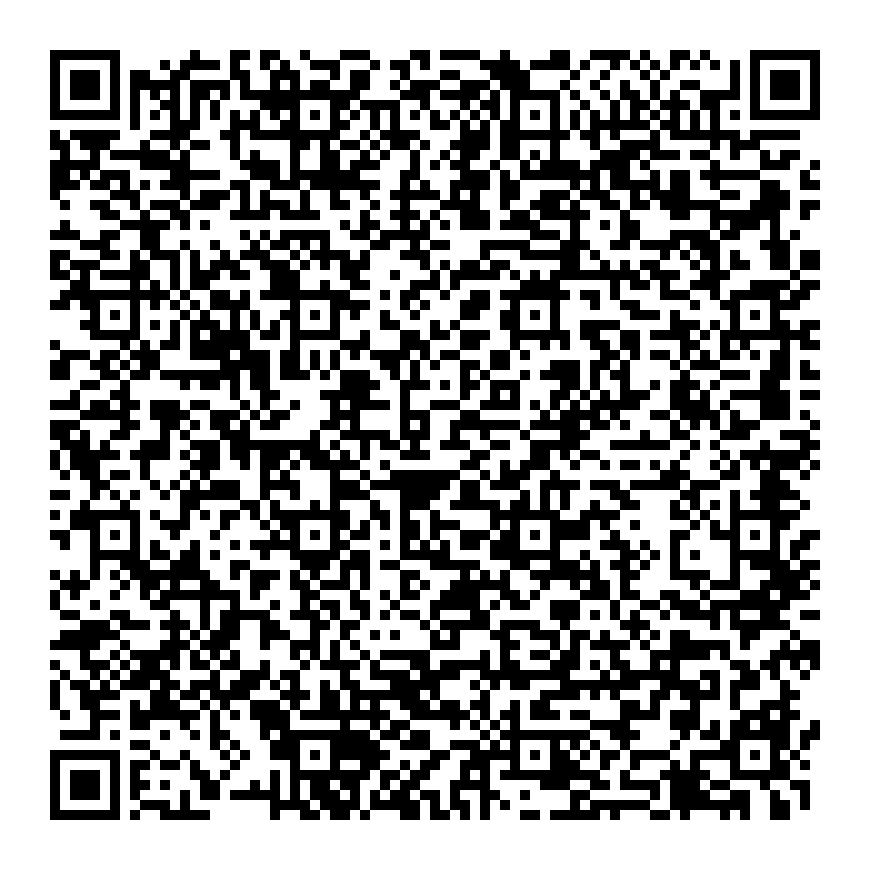

Connection message {'their_label': 'EAX', 'connection_id': '255cdcc1-4b68-427d-8a6e-200fe75e6dc3', 'routing_state': 'none', 'invitation_mode': 'once', 'updated_at': '2020-09-22 09:38:07.643828Z', 'invitation_key': 'BdrrnhGgvSpJExbDBHqst9cLKqsdY31q6GnNcsfJ3Bf5', 'accept': 'auto', 'their_did': 'AxAbe3dPFCB3z3VctE6W7F', 'initiator': 'self', 'created_at': '2020-09-22 09:37:53.153513Z', 'state': 'request'} 255cdcc1-4b68-427d-8a6e-200fe75e6dc3
Connection message {'their_label': 'EAX', 'connection_id': '255cdcc1-4b68-427d-8a6e-200fe75e6dc3', 'routing_state': 'none', 'invitation_mode': 'once', 'updated_at': '2020-09-22 09:38:07.671900Z', 'invitation_key': 'BdrrnhGgvSpJExbDBHqst9cLKqsdY31q6GnNcsfJ3Bf5', 'accept': 'auto', 'my_did': '9BXTvm1nufAjyC7gZPvHV8', 'their_did': 'AxAbe3dPFCB3z3VctE6W7F', 'initiator': 'self', 'created_at': '2020-09-22 09:37:53.153513Z', 'state': 'response'} 255cdcc1-4b68-427d-8a6e-200fe75e6dc3


In [4]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

## 3c. Check if established connection is in active state

In [5]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId 255cdcc1-4b68-427d-8a6e-200fe75e6dc3 is response
ConnectionId 255cdcc1-4b68-427d-8a6e-200fe75e6dc3 is not in active state yet
Trust ping send to ConnectionId {'thread_id': '82613134-bf7b-4ece-b1e0-9b8563480ae8'} to activate connection
ConnectionId 255cdcc1-4b68-427d-8a6e-200fe75e6dc3 is not in active state yet
Connection message {'their_label': 'EAX', 'connection_id': '255cdcc1-4b68-427d-8a6e-200fe75e6dc3', 'routing_state': 'none', 'invitation_mode': 'once', 'updated_at': '2020-09-22 09:38:14.692863Z', 'invitation_key': 'BdrrnhGgvSpJExbDBHqst9cLKqsdY31q6GnNcsfJ3Bf5', 'accept': 'auto', 'my_did': '9BXTvm1nufAjyC7gZPvHV8', 'their_did': 'AxAbe3dPFCB3z3VctE6W7F', 'initiator': 'self', 'created_at': '2020-09-22 09:37:53.153513Z', 'state': 'active'} 255cdcc1-4b68-427d-8a6e-200fe75e6dc3
Connection 255cdcc1-4b68-427d-8a6e-200fe75e6dc3 changed state to active
Trust ping send to ConnectionId {'thread_id': '9ef02849-1d65-40d1-86bd-ac6632c2dc9e'} to activate connection

## 4. Retrieve stored cred_def_id and schema_id


In [6]:
%store -r cred_def_id
%store -r schema_id
print(schema_id)
print(cred_def_id)

2yWoMSfeTtYBFpUJFcnpqL:2:GMC Registration:0.0.1
74dSKxrtMCZu3RXc8DwpxN:3:CL:141256:default


## 4. Send proof request(s) to populate credentials

## 4a. Generate proof request

In [ ]:
# schema_id = 'EuEtnVakYFyBtGFT1nHYtH:2:SSI PyDentity Tutorial:0.0.1'

# print("Request proof of Fullname and Age range from Identity Holder")
# #Set some variables

# revocation = False
# SELF_ATTESTED = True
# exchange_tracing = False

# #Enable this to ask for attributes to identity a user
# #TODO - change restriction to schemaId or credentialId

# req_attrs = [
#     {"name": "fullname", "restrictions": [{"schema_id": schema_id}]},
#     {"name": "skill", "restrictions": [{"schema_id": schema_id}]},
# ]

# if revocation:
#     req_attrs.append(
#         {
#             "name": "skill",
#             "restrictions": [{"schema_id": schema_id}],
#             "non_revoked": {"to": int(time.time() - 1)},
#         },
#     )

# if SELF_ATTESTED:
#     # test self-attested claims
#     req_attrs.append({"name": "country"},)

# #Set predicates for Zero Knowledge Proofs
# req_preds = [
#     # test zero-knowledge proofs
#     {
#         "name": "age",
#         "p_type": ">=",
#         "p_value": 21,
#         "restrictions": [{"schema_id": schema_id}],
#     }
# ]

# indy_proof_request = {
#     "name": "Proof of Completion of PyDentity SSI Tutorial",
#     "version": "1.0",
#     "requested_attributes": {
#         f"0_{req_attr['name']}_uuid":
#         req_attr for req_attr in req_attrs
#     },
#     "requested_predicates": {
#         f"0_{req_pred['name']}_GE_uuid":
#         req_pred for req_pred in req_preds
#     },
# }

# if revocation:
#     indy_proof_request["non_revoked"] = {"to": int(time.time())}

# #proof_request = indy_proof_request
# exchange_tracing_id = exchange_tracing
# proof_request_web_request = {
#     "connection_id": connection_id,
#     "proof_request": indy_proof_request,
#     "trace": exchange_tracing,
# }

In [11]:
print(schema_id)
print(cred_def_id)

# {
#        "attrNames":[
#            "PSS Passport No",
#            "PSS Surname",
#            "PSS Given Names",
#            "PSS Nationality",
#            "PSS Date of Birth",
#            "PSS Sex",
#            "PSS Place of Birth",
#            "PSS Date of Issue",
#            "PSS IssuingAuthority",
#            "PSS Date Of Expiry",
#            "PSS Photograph",
#            "PSS Signature"
#        ],
#        "name":"Passport Details",
#        "version":"0.0.1"
# }

# {
#        "attrNames":[
#            "MDQ Primary Medical Qual",
#            "MDQ Issuing Institution",
#            "MDQ Surname",
#            "MDQ Given Names",
#            "MDQ Issue Date"
#        ],
#        "name":"Medical Qual",
#        "version":"0.0.1"
# }


print("Request proof of Passport and Medical School information")

#Set some variables

REVOCATION = False
SELF_ATTESTED = False
EXCHANGE_TRACING = False

req_attrs = [
    {"name": "PSS Given Names", "restrictions": []},
    {"name": "PSS Surname", "restrictions": []},
    {"name": "PSS Sex", "restrictions": []},
    {"name": "MDQ Primary Medical Qual", "restrictions": []},
]

if REVOCATION:
    req_attrs.append(
        {
            "name": "skill",
            "restrictions": [{"schema_id": schema_id}],
            "non_revoked": {"to": int(time.time() - 1)},
        },
    )

if SELF_ATTESTED:
    # test self-attested claims
    req_attrs.append({"name": "country"},)

#Set predicates for Zero Knowledge Proofs
req_preds = []

indy_proof_request = {
    "name": "Proof of Passport Credential",
    "version": "1.0",
    "requested_attributes": {
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
    "requested_predicates": {
        f"0_{req_pred['name']}_GE_uuid":
        req_pred for req_pred in req_preds
    },
}

if REVOCATION:
    indy_proof_request["non_revoked"] = {"to": int(time.time())}

#proof_request = indy_proof_request
exchange_tracing_id = EXCHANGE_TRACING
proof_request_web_request = {
    "connection_id": connection_id,
    "proof_request": indy_proof_request,
    "trace": EXCHANGE_TRACING,
}

2yWoMSfeTtYBFpUJFcnpqL:2:GMC Registration:0.0.1
74dSKxrtMCZu3RXc8DwpxN:3:CL:141256:default
Request proof of Passport and Medical School information


### 4b. Send the proof request to Doctor

Doctor is identified through the connection_id

In [12]:
response = await agent_controller.proofs.send_request(proof_request_web_request)
print(response)
presentation_exchange_id = response['presentation_exchange_id']
print("\n")
print(presentation_exchange_id)

{'presentation_request': {'name': 'Proof of Passport Credential', 'version': '1.0', 'requested_attributes': {'0_PSS Given Names_uuid': {'name': 'PSS Given Names', 'restrictions': []}, '0_PSS Surname_uuid': {'name': 'PSS Surname', 'restrictions': []}, '0_PSS Sex_uuid': {'name': 'PSS Sex', 'restrictions': []}, '0_MDQ Primary Medical Qual_uuid': {'name': 'MDQ Primary Medical Qual', 'restrictions': []}}, 'requested_predicates': {}, 'nonce': '426251401059084063120248'}, 'connection_id': '255cdcc1-4b68-427d-8a6e-200fe75e6dc3', 'state': 'request_sent', 'auto_present': False, 'thread_id': '85ed7a61-4c85-4dd3-b232-86e7d6de3a24', 'updated_at': '2020-09-22 09:56:30.053256Z', 'initiator': 'self', 'role': 'verifier', 'presentation_request_dict': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/present-proof/1.0/request-presentation', '@id': '85ed7a61-4c85-4dd3-b232-86e7d6de3a24', 'request_presentations~attach': [{'@id': 'libindy-request-presentation-0', 'mime-type': 'application/json', 'data': {'base

## 4c. Verify proof presentation and populate credential template

This is checking the signatures on the credentials presented against the credential schema and definition id stored and resolvable on the ledger. It is a bit of a big complicated object, so we show the common pattern for breaking it down, checking it's verified and accessing the data that has been presented.

In [14]:
verify = await agent_controller.proofs.verify_presentation(presentation_exchange_id)

# print proof request verification status
print('Proof request state verified?: {} '.format(verify['state'] == 'verified'))


Proof request state verified?: True 
{'sub_proof_index': 1, 'raw': 'Jones', 'encoded': '114927502338763998064999850638882995061695907387154193658986605318642155271625'}
Jones
{'sub_proof_index': 0, 'raw': 'MSc Comp Sci', 'encoded': '102149397172384055645750535706078428299164809356240582091983477374279459271703'}
MSc Comp Sci
{'sub_proof_index': 1, 'raw': 'F', 'encoded': '111485737994509659498044467867576034197262524114183546611539441564110959814825'}
F
{'sub_proof_index': 1, 'raw': 'Bob', 'encoded': '93006290325627508022776103386395994712401809437930957652111221015872244345185'}
Bob


In [30]:
# access the revealed attributes and populate credential
credential_attributes = []
for (name, val) in verify['presentation']['requested_proof']['revealed_attrs'].items():
    ## This is the actual data that you want. It's a little hidden
    print('Atribute name: GMC {} Value: {}'.format(name[6:-5],val['raw']))
#     credential_attributes.add{"name": "GMC " + name[6:-5], "value": val['raw']}

Atribute name: GMC Surname Value: Jones
Atribute name: GMC Primary Medical Qual Value: MSc Comp Sci
Atribute name: GMC Sex Value: F
Atribute name: GMC Given Names Value: Bob


In [27]:
print(credential_attributes)

[{'name': 'GMC Given Names', 'value': 'Bob'}]


In [ ]:
# reg_status = input("Please enter your reg_status")
# ftp_status = input("Please enter your FTP status")
# medical_qual = input("Please enter your primary medical qualification")
# prov_reg_date =("Please enter your provisional registration date")
# full_reg_date =("Please enter your full reg date")
# spec_register_status =("Please enter your Spec. register status")
# primary_speciality =("Please enter your primary speciality")
# gp_register_status =("Please enter your gp register status")
# gp_register_date =("Please enter your gp register date")
# revalidation_status =("Please enter your revalidation status")
# training_information =("Please enter your training information")
# designated_body =("Please enter your designated body")
# responsible_officer =("Please enter your Responsible Officer")

In [ ]:
credential_attributes = [
    {"name": "GMC Reference Number", "value": reference_number},
    {"name": "GMC Given Name", "value": name},
    {"name": "GMC Surname", "value": surname},
    {"name":"GMC Gender", "value": gender},
    {"name":"GMC Reg Status", "value": "Active"},
    {"name":"GMC FTP Status", "value": "Active"},
    {"name":"GMC Primary Medical Qual", "value":"Paediatrition"},
    {"name":"GMC Prov Reg Date", "value":"00/00/00"},
    {"name":"GMC Full Reg Date", "value":"00/00/00"},
    {"name":"GMC Spec. Register Status", "value":"Active"},
    {"name":"GMC Primary Specialty", "value":"Paediatrics"},
    {"name":"GMC GP Register Status", "value":"Active"},
    {"name":"GMC GP Register Date", "value":"00/00/00"},
    {"name":"GMC Revalidation Status", "value":"Active"},
    {"name":"GMC Training Information", "value":"Stage 1"},
    {"name":"GMC Designated Body", "value":"NHS"},
    {"name":"GMC Responsible Officer", "value":"Head Doctor"}

## 5. Populate the GMC Registration attributes

In [7]:
reference_number=input("Please enter your reference number: ")
name=input("Please enter your name ")
surname = input("Please enter your surname")
gender = input("Please enter your gender")
# reg_status = input("Please enter your reg_status")
# ftp_status = input("Please enter your FTP status")
# medical_qual = input("Please enter your primary medical qualification")
# prov_reg_date =("Please enter your provisional registration date")
# full_reg_date =("Please enter your full reg date")
# spec_register_status =("Please enter your Spec. register status")
# primary_speciality =("Please enter your primary speciality")
# gp_register_status =("Please enter your gp register status")
# gp_register_date =("Please enter your gp register date")
# revalidation_status =("Please enter your revalidation status")
# training_information =("Please enter your training information")
# designated_body =("Please enter your designated body")
# responsible_officer =("Please enter your Responsible Officer")
credential_attributes = [
    {"name": "GMC Reference Number", "value": reference_number},
    {"name": "GMC Given Name", "value": name},
    {"name": "GMC Surname", "value": surname},
    {"name":"GMC Gender", "value": gender},
    {"name":"GMC Reg Status", "value": "Active"},
    {"name":"GMC FTP Status", "value": "Active"},
    {"name":"GMC Primary Medical Qual", "value":"Paediatrition"},
    {"name":"GMC Prov Reg Date", "value":"00/00/00"},
    {"name":"GMC Full Reg Date", "value":"00/00/00"},
    {"name":"GMC Spec. Register Status", "value":"Active"},
    {"name":"GMC Primary Specialty", "value":"Paediatrics"},
    {"name":"GMC GP Register Status", "value":"Active"},
    {"name":"GMC GP Register Date", "value":"00/00/00"},
    {"name":"GMC Revalidation Status", "value":"Active"},
    {"name":"GMC Training Information", "value":"Stage 1"},
    {"name":"GMC Designated Body", "value":"NHS"},
    {"name":"GMC Responsible Officer", "value":"Head Doctor"}
    
    
]
print(credential_attributes)

Please enter your reference number: 2334
Please enter your name VIneeth
Please enter your surnameR
Please enter your genderM
[{'name': 'GMC Reference Number', 'value': '2334'}, {'name': 'GMC Given Name', 'value': 'VIneeth'}, {'name': 'GMC Surname', 'value': 'R'}, {'name': 'GMC Gender', 'value': 'M'}, {'name': 'GMC Reg Status', 'value': 'Active'}, {'name': 'GMC FTP Status', 'value': 'Active'}, {'name': 'GMC Primary Medical Qual', 'value': 'Paediatrition'}, {'name': 'GMC Prov Reg Date', 'value': '00/00/00'}, {'name': 'GMC Full Reg Date', 'value': '00/00/00'}, {'name': 'GMC Spec. Register Status', 'value': 'Active'}, {'name': 'GMC Primary Specialty', 'value': 'Paediatrics'}, {'name': 'GMC GP Register Status', 'value': 'Active'}, {'name': 'GMC GP Register Date', 'value': '00/00/00'}, {'name': 'GMC Revalidation Status', 'value': 'Active'}, {'name': 'GMC Training Information', 'value': 'Stage 1'}, {'name': 'GMC Designated Body', 'value': 'NHS'}, {'name': 'GMC Responsible Officer', 'value': '

## 6. Send Credential

This sends a credential to a identity holder (User), and automates the rest of the protocol.

There are other ways to issue a credential that require multiple api calls.

**Arguments**
* connection_id: The connection_id of the holder you wish to issue to (MUST be in active state)
* schema_id: The id of the schema you wish to issue
* cred_def_id: The definition (public key) to sign the credential object. This must refer to the schema_id and be written to the ledger by the same public did that is currently being used by the agent.
* attributes: A list of attribute objects as defined above. Must match the schema attributes.
* comment (optional): Any string, defaults to ""
* auto_remove (optional): Boolean, defaults to True. I believe this removes the record of this credential once it has been issued. (TODO: double check)
* trace (optional): Boolean, defaults to False. **Not entirely sure about this one, believe its for logging. Also when set to True it throws an error**

In [12]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


Handle Credentials
Credential exchange 7aa94eea-2978-459e-b868-1da07cd94113, role: issuer, state: offer_sent
Offering: [{'name': 'GMC Reference Number', 'value': '2334'}, {'name': 'GMC Given Name', 'value': 'VIneeth'}, {'name': 'GMC Surname', 'value': 'R'}, {'name': 'GMC Gender', 'value': 'M'}, {'name': 'GMC Reg Status', 'value': 'Active'}, {'name': 'GMC FTP Status', 'value': 'Active'}, {'name': 'GMC Primary Medical Qual', 'value': 'Paediatrition'}, {'name': 'GMC Prov Reg Date', 'value': '00/00/00'}, {'name': 'GMC Full Reg Date', 'value': '00/00/00'}, {'name': 'GMC Spec. Register Status', 'value': 'Active'}, {'name': 'GMC Primary Specialty', 'value': 'Paediatrics'}, {'name': 'GMC GP Register Status', 'value': 'Active'}, {'name': 'GMC GP Register Date', 'value': '00/00/00'}, {'name': 'GMC Revalidation Status', 'value': 'Active'}, {'name': 'GMC Training Information', 'value': 'Stage 1'}, {'name': 'GMC Designated Body', 'value': 'NHS'}, {'name': 'GMC Responsible Officer', 'value': 'Head D

## 7. Accept credential in Mobile SSI Wallet

## 8. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [18]:
response = await agent_controller.terminate()
print(response)

None


# Congratulations you are now a licenced doctor. Proceed to the [Health Education England](http://localhost:8891/tree?) to receive your training.

You can get the notebook access token by running this in the terminal `docker logs  interopen-hack_hee-notebook_1
`